# What can opal tap-on/tap-off data tell us?

I have been living in Sydney for the past ten years and been experiencing significant public transport improvements. The notable one is the introduction of Opal Card, a contactless fare collection system. The card makes it easier to travel, as it is acceptable in multiple transport modes.

## Business understanding

The Transport for NSW Open Data Hub produces several open data related to Opal Card, including the Opal Trip – Train (https://opendata.transport.nsw.gov.au/dataset/opal-trips-train). I am curious whether I could use this data to answer the following questions:

- **Question 1.** Which train line has the highest annual trips?

- **Question 2.** What are the proportions of full, reduced and free fare trips in each of the train lines?

- **Question 3.** What is the impact of COVID-19 on the number of trips made on the train lines?

Before exploring and analysing the data, it would be good to know the Sydney Trains network. Following image shows the Sydney Trains Network Map. Currently, there are eight train lines connecting stations within the Sydney metropolitan areas.

<img src="sydney-trains-network-map.png" width=653 height=926/>

Source: (https://transportnsw.info/sydney-trains-network-map)

## Data Understanding
### Gathering data

The Transport for NSW Open Data Hub had six datasets related to travel on Sydney Trains.

1. Train Station Maps (including Metro)
2. Opal Trips - Train
3. Opal Trips - All Modes
4. ROAM - Rail Opal Assignment Model
5. Train Occupancy - Nov 2018 to Feb 2019
6. Opal Patronage

Based on the data documentation, only the second and third data contains the consolidated number of travels. I selected the second data as it stores the number of travel for trains explicitly.

In [1]:
# import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display
%matplotlib inline

# set to show all rows
pd.set_option('display.max_rows', 10)

# set display format for float
pd.set_option("display.float_format", "{:.2f}".format)

### Assessing data

In [2]:
# read data
df = pd.read_csv("Train Card Type.csv",encoding="utf-16", sep="\t", thousands=",")

In [3]:
# check data
print(df.head())

                                  Unnamed: 0                    Unnamed: 1  \
0  T1 North Shore, Northern and Western Line                         Adult   
1  T1 North Shore, Northern and Western Line                   Child/Youth   
2  T1 North Shore, Northern and Western Line                    Concession   
3  T1 North Shore, Northern and Western Line  Day Pass Child/Youth w/o SAF   
4  T1 North Shore, Northern and Western Line          Day Pass without SAF   

   July 2016  August 2016  September 2016  October 2016  November 2016  \
0 8575135.00   9484134.00      8956112.00    8778524.00     9221978.00   
1  432083.00    370300.00       425154.00     438430.00      404288.00   
2  790206.00   1081373.00       855554.00     839434.00      677907.00   
3        nan          nan             nan           nan            nan   
4        nan          nan             nan           nan            nan   

   December 2016  January 2017  February 2017  ...  February 2020  March 2020  \
0    

At a glance, the dataset contains the number of trips made on train lines from July 2016 to November 2020. The data is presented by train lines (column 1) and card types (column 2).

In [4]:
# check unique values
print(sorted(df["Unnamed: 0"].unique()))

['Blue Mountains Line', 'Central Coast Newcastle Line', 'Grand Total', 'Hunter Line', 'South Coast Line', 'Southern Highlands Line', 'Station Link', 'T1 North Shore Line', 'T1 North Shore, Northern and Western Line', 'T1 Northern Line', 'T1 Western Line', 'T2 Airport, Inner West and South Line', 'T2 Inner West Line', 'T2 Leppington Line', 'T3 Bankstown Line', 'T4 Eastern Suburbs and Illawarra Line', 'T5 Cumberland Line', 'T6 Carlingford Line', 'T6 replacement buses', 'T7 Olympic Park Line', 'T8 Airport and South Line', 'T9 Northern Line']


Upon further inspection on the first column, I can see that apart from Sydney Trains, the data also includes Intercity Trains, Station Link and Replacement Bus. The information is including the predecessor of the current train lines, for example, T1 North Shore, Northern and Western Line.

In [5]:
print(sorted(df["Unnamed: 1"].unique()))

['Adult', 'CTP', 'Child/Youth', 'Concession', 'Day Pass Child/Youth w/o SAF', 'Day Pass without SAF', 'Employee', 'Free Travel', 'School Student', 'Senior/Pensioner', 'Sgl Trip Rail Adult', 'Sgl Trip Rail Child/Youth', 'Total']


The dataset also contains a breakdown of trips based on the type of cards used to tap-on/tap-off, presented in the second column. This information is useful as a proxy to differentiate the trip using full, reduced, and free fare.

In [6]:
# describe data
print(df.describe())

        July 2016  August 2016  September 2016  October 2016  November 2016  \
count      109.00       109.00          109.00        109.00         109.00   
mean    528793.56    594384.95       562355.08     552418.95      574647.32   
std    2925556.60   3277859.48      3103018.57    3047376.60     3174762.95   
min          2.00         4.00            7.00          3.00           3.00   
25%       1087.00      2343.00         2136.00       2151.00        2210.00   
50%       9780.00     15391.00        15599.00      15796.00       15602.00   
75%      83619.00    118953.00       108657.00     114758.00      114496.00   
max   28819249.00  32393980.00     30648352.00   30106833.00    31318279.00   

       December 2016  January 2017  February 2017  March 2017  April 2017  \
count         109.00        109.00         109.00      109.00      109.00   
mean       517240.07     490558.20      527835.52   634245.60   527444.57   
std       2855014.82    2713208.69     2916649.57  349444

The number of non-null rows varies between each column, which indicates some missing values.

In [7]:
# check number of rows and column
print("number of rows {} is and number of colum {}".format(df.shape[0], df.shape[1]))

number of rows 247 is and number of colum 55


This confirms that there are missing values since the count for all columns is lower than 247.

## Data Preparation
### Cleaning data
Based on the initial data assessment, I noticed the following:
1. Missing field name for the first and second column. I will rename these columns to train_line and card_type accordingly.
2. Missing values. The missing values will be replaced with 0, as I am interested in the number of trips. Replacing the missing value by 0 also will not affect the subsequent analysis, as it will mostly focus on sum and proportion.
3. The number of trips is presented as floating instead of an integer. The data type will be converted to an integer.

In [8]:
# rename first and second column as the data source does not have field name
df.rename(columns={"Unnamed: 0": "train_line", "Unnamed: 1": "card_type"}, inplace=True)

In [9]:
# change data type to int and populate nan with 0
for intCol in [colName for colName in df.columns if "20" in colName]:
    df[intCol] = df[intCol].fillna(0).astype(int)

In [10]:
# describe data after fixing missing values
print(df.describe())

        July 2016  August 2016  September 2016  October 2016  November 2016  \
count      247.00       247.00          247.00        247.00         247.00   
mean    233354.24    262299.43       248164.79     243780.02      253589.30   
std    1956215.73   2191916.34      2074977.76    2037780.09     2122905.38   
min          0.00         0.00            0.00          0.00           0.00   
25%          0.00         0.00            0.00          0.00           0.00   
50%          0.00         0.00            0.00          0.00           0.00   
75%       7551.00     11551.50         9825.50      10965.50       10228.00   
max   28819249.00  32393980.00     30648352.00   30106833.00    31318279.00   

       December 2016  January 2017  February 2017  March 2017  April 2017  \
count         247.00        247.00         247.00      247.00      247.00   
mean       228255.74     216481.15      232931.47   279889.76   232758.94   
std       1909127.13    1814236.03     1950303.57  233678

### Constructing data
Since I am only interested in the number of trips in Sydney Trains, I will be excluding the Intercity Trains, Station Link and Replacement Bus data from the analysis.

The data also contains "Total" and "Grand Total" rows that will be excluded from the analysis.

I used "isin" to subset the data frame to includes only records that I am interested in.

In [11]:
# only kept data rows related to Sydney Train
cityTrainDf = df[df.train_line.isin(['T1 North Shore Line',
                                     'T1 North Shore, Northern and Western Line',
                                     'T1 Northern Line',
                                     'T1 Western Line',
                                     'T2 Airport, Inner West and South Line',
                                     'T2 Inner West Line',
                                     'T2 Leppington Line',
                                     'T3 Bankstown Line',
                                     'T4 Eastern Suburbs and Illawarra Line',
                                     'T5 Cumberland Line',
                                     'T6 Carlingford Line',
                                     'T7 Olympic Park Line',
                                     'T8 Airport and South Line',
                                     'T9 Northern Line'])]

In [12]:
# function to aggregate monthly trip data to year
def aggTripByYear (dataFrame, year):
    """Aggregate monthly trip data to year.
    
    Args:
        dataFrame. Data frame contains monthly data.
        year. Aggregated Year.
    
    Returns:
        dataFrame. Data frame with aggregated annual trip data.
        
    """
    
    # find columns that match year
    yearRegex = "{}$".format(year)
    
    # aggregate
    dataFrame[year] = dataFrame.filter(regex=yearRegex).sum(axis=1, skipna=True)
    
    return dataFrame

In [13]:
# aggregate by year
yearList = ["2016", "2017", "2018", "2019", "2020"]
for year in yearList:
    cityTrainDf = aggTripByYear (cityTrainDf, year)

D:\ProgramData\Anaconda3\envs\conda_python_36\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [14]:
# show sample aggregated data by year
cityTrainDf[["train_line", "card_type", "2016", "2017", "2018", "2019", "2020"]]

,train_line,card_type,2016,2017,2018,2019,2020
0,"T1 North Shore, Northern and Western Line",Adult,53052085,100316396,0,0,0
1,"T1 North Shore, Northern and Western Line",Child/Youth,2575656,4886757,0,0,0
2,"T1 North Shore, Northern and Western Line",Concession,4769223,9231214,0,0,0
3,"T1 North Shore, Northern and Western Line",Day Pass Child/Youth w/o SAF,0,22,0,0,0
4,"T1 North Shore, Northern and Western Line",Day Pass without SAF,0,113,0,0,0
...,...,...,...,...,...,...,...
241,T9 Northern Line,Free Travel,0,0,0,10852,7475
242,T9 Northern Line,School Student,0,0,0,615584,525723
243,T9 Northern Line,Senior/Pensioner,0,0,0,1564250,1049831
244,T9 Northern Line,Sgl Trip Rail Adult,0,0,0,45981,16360


This will provide me with the basic structure to further aggregate or process to answer questions 1 and 2.

In [15]:
# show sample aggregated data by month
cityTrainDf[["train_line", "card_type", "January 2020", "February 2020",
             "March 2020", "April 2020", "May 2020", "June 2020",
             "July 2020", "August 2020", "September 2020", "October 2020",
             "November 2020"]]

,train_line,card_type,January 2020,February 2020,March 2020,April 2020,May 2020,June 2020,July 2020,August 2020,September 2020,October 2020,November 2020
0,"T1 North Shore, Northern and Western Line",Adult,0,0,0,0,0,0,0,0,0,0,0
1,"T1 North Shore, Northern and Western Line",Child/Youth,0,0,0,0,0,0,0,0,0,0,0
2,"T1 North Shore, Northern and Western Line",Concession,0,0,0,0,0,0,0,0,0,0,0
3,"T1 North Shore, Northern and Western Line",Day Pass Child/Youth w/o SAF,0,0,0,0,0,0,0,0,0,0,0
4,"T1 North Shore, Northern and Western Line",Day Pass without SAF,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,T9 Northern Line,Free Travel,1111,1182,820,150,320,542,613,599,629,735,774
242,T9 Northern Line,School Student,9879,85654,62380,256,25009,64900,37671,65273,59870,47876,66955
243,T9 Northern Line,Senior/Pensioner,164343,151966,103786,28912,52160,77822,83788,82068,88680,100371,115935
244,T9 Northern Line,Sgl Trip Rail Adult,4266,3679,1854,251,560,1015,994,753,806,1022,1160


Whereas this will provide me with a data structure to answer question 3.

## Question 1. Which train line has the highest annual trips?

### Q1 Modelling data
Since I already have the necessary basic data structure. To answer this question, I need to aggregate the data by train lines and year only.

In [16]:
# group data by train line
cityTrainGroupDf = cityTrainDf.groupby(["train_line"], as_index=True)[yearList].apply(sum)

### Q1 Analysing and visualising data
A simple visualisation is applied to highlight each column's highest value, which I frequently used in Excel.


In [17]:
# most opal trip in each year
for year in yearList:
    yearMaxTripDf = cityTrainGroupDf[[year]][cityTrainGroupDf[year] == cityTrainGroupDf[year].max()]
    print("In year {} - train line {} - has most opal trip with {} trips"
          .format(year, yearMaxTripDf.iloc[[0]].index.to_list(), yearMaxTripDf.iloc[0,0]))

In year 2016 - train line ['T1 North Shore, Northern and Western Line'] - has most opal trip with 69487549 trips
In year 2017 - train line ['T1 North Shore, Northern and Western Line'] - has most opal trip with 131495077 trips
In year 2018 - train line ['T4 Eastern Suburbs and Illawarra Line'] - has most opal trip with 68784319 trips
In year 2019 - train line ['T4 Eastern Suburbs and Illawarra Line'] - has most opal trip with 70000831 trips
In year 2020 - train line ['T4 Eastern Suburbs and Illawarra Line'] - has most opal trip with 35507570 trips


In [18]:
# most opal trip in each year
cityTrainGroupDf.style.highlight_max(subset=yearList, color="yellow", axis=0)

,2016,2017,2018,2019,2020
train_line,,,,,
T1 North Shore Line,0,3565251,44364600,61146155,26825666
"T1 North Shore, Northern and Western Line",69487549,131495077,0,0,0
T1 Northern Line,0,4610475,45617901,8843888,0
T1 Western Line,0,4239293,50812862,52082851,25583242
"T2 Airport, Inner West and South Line",42148307,81293299,0,0,0
T2 Inner West Line,0,2073237,24345176,25244214,12769102
T2 Leppington Line,0,3049196,33205694,33909656,17471810
T3 Bankstown Line,13604289,27564576,29695882,29844214,15449804
T4 Eastern Suburbs and Illawarra Line,32094760,66585455,68784319,70000831,35507570


### Q1 Evaluation
Based on the above table, T1 North Shore, Northern and Western Line is a clear winner in 2016 and 2017. 

However, in 2018 the T4 Eastern Suburbs and Illawarra Line took the lead in the highest number of trips. 

This shift is due to the following changes:

1. On 26 November 2017 the T1 North Shore, Northern and Western Line was redefined into following lines:
   - T1 North Shore Line.
   - T1 Northern Line.
   - T1 Western Line.
2. On 26 November 2017 the T2 Airport, Inner West and South Line was split into:
   - T2 Inner West Line.
   - T2 Leppington Line.
   - T8 Airport and South Line.
3. On 28 April 2019, the T1 Northern Line was renamed to T9 Northern Line.
4. On 5 January 2020, the T6 Carlingford Line was closed and converted to light rail.

## Question 2. What are the proportions full, reduced and free fare trips in each of the train lines?

### Q2 Modelling data
The trip data was aggregated based on three categories based on the card type used for tap-on/tap-off.
1. Full fare (Adult, CTP, Day Pass without SAF, and Sgl Trip Rail Adult)
2. Discounted fare (Child/Youth, Concession, Day Pass Child/Youth w/o SAF, Senior/Pensioner, and Sgl Trip Rail Child/Youth)
3. Free fare (Employee, Free Travel, and School Student)

In [19]:
# function to aggregate data by fare type
def aggFare (dataFrame, cardList, subList, groupList, yearList, colName):
    """Aggregate data by fare type.
    
    Args:
        dataFrame. Input data frame.
        cardTypes. List of card types. This will be used to match the rows used in the process.
        subList. List of columns to be used in this function.
        groupList. List of columns used in the group by.
        yearList. List of year to be processed.
        colName. Column name to store output
    
    Returns:
        dataFrame. Data frame with aggregated fare type.
        
    """
    
    # subset data by card type
    fareDataFrame = dataFrame[dataFrame.card_type.isin(cardList)][subList].groupby(groupList, as_index=True)[yearList].apply(sum)
    
    # aggregate to new column
    fareDataFrame[colName] = fareDataFrame.sum(axis=1)
    
    # reset index
    fareDataFrame.reset_index(inplace=True)
    
    return fareDataFrame

In [20]:
# set parameters to calculate fare proportions
fullFareCardList = ["Adult", "CTP", "Day Pass without SAF", "Sgl Trip Rail Adult"]
discFareCardList = ["Child/Youth", "Concession", "Day Pass Child/Youth w/o SAF", 
                    "Senior/Pensioner", "Sgl Trip Rail Child/Youth"]
freeFareCardList = ["Employee", "Free Travel", "School Student"]
subList = ["train_line", "2016", "2017", "2018", "2019", "2020"]
groupList = ["train_line"]

# filter by full fare
fullFareTravelDf = aggFare(cityTrainDf, fullFareCardList, subList, groupList, yearList, "full_fare")

# filter by discounter fare
discFareTravelDf = aggFare(cityTrainDf, discFareCardList, subList, groupList, yearList, "disc_fare")

# filter by free travel
freeTravelDf = aggFare(cityTrainDf, freeFareCardList, subList, groupList, yearList, "free_fare")

### Q2 Analysing and visualising data
I also need to calculate the proportion of each fare type to its total value. This is to reduce bias, as some line such T6 Carlingford Line has much lower trips than others, which is primarily due to its shorter line.

In [21]:
# join free travel df and fullFare travel df
travelDf = fullFareTravelDf.merge(discFareTravelDf[["train_line", "disc_fare"]], on="train_line", how="outer")
travelDf = travelDf.merge(freeTravelDf[["train_line", "free_fare"]], on="train_line", how="outer")

# calculate proportion
fareList = ["full_fare", "disc_fare", "free_fare"]
for fareLst in fareList:
    pctFareLst = "pct_{}".format(fareLst)
    travelDf[pctFareLst] = travelDf[fareLst] * 100e0 / travelDf[fareList].sum(axis=1)

# only keep proportion columns
travelDf.drop(["2016", "2017", "2018", "2019", "2020", "full_fare", "disc_fare", "free_fare"], axis=1,  inplace=True)

In [22]:
# highlight highest proportion
travelDf.style.highlight_max(subset=["pct_full_fare","pct_disc_fare", "pct_free_fare"], color="yellow", axis=0)

,train_line,pct_full_fare,pct_disc_fare,pct_free_fare
0,T1 North Shore Line,78.172438,17.067407,4.760156
1,"T1 North Shore, Northern and Western Line",76.963473,18.873845,4.162682
2,T1 Northern Line,78.601981,17.767997,3.630022
3,T1 Western Line,77.048192,18.276172,4.675636
4,"T2 Airport, Inner West and South Line",78.337678,18.535904,3.126418
5,T2 Inner West Line,80.876250,15.865412,3.258339
6,T2 Leppington Line,75.840203,20.424999,3.734798
7,T3 Bankstown Line,75.885694,21.020968,3.093338
8,T4 Eastern Suburbs and Illawarra Line,79.936706,16.674274,3.389020
9,T5 Cumberland Line,76.191683,20.271091,3.537226


In [23]:
# highlight lowest proportion
travelDf.style.highlight_min(subset=["pct_full_fare","pct_disc_fare", "pct_free_fare"], color="yellow", axis=0)

,train_line,pct_full_fare,pct_disc_fare,pct_free_fare
0,T1 North Shore Line,78.172438,17.067407,4.760156
1,"T1 North Shore, Northern and Western Line",76.963473,18.873845,4.162682
2,T1 Northern Line,78.601981,17.767997,3.630022
3,T1 Western Line,77.048192,18.276172,4.675636
4,"T2 Airport, Inner West and South Line",78.337678,18.535904,3.126418
5,T2 Inner West Line,80.876250,15.865412,3.258339
6,T2 Leppington Line,75.840203,20.424999,3.734798
7,T3 Bankstown Line,75.885694,21.020968,3.093338
8,T4 Eastern Suburbs and Illawarra Line,79.936706,16.674274,3.389020
9,T5 Cumberland Line,76.191683,20.271091,3.537226


In [24]:
# melt data for visualisation purposes
travelDf = travelDf.melt(["train_line"], var_name="fare_type", value_name="opal_trip")

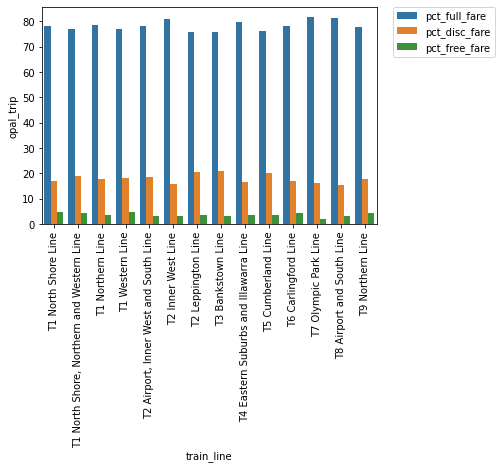

In [25]:
# plot data
ax = sns.barplot(x="train_line", y="opal_trip", hue="fare_type", data=travelDf)
plt.xticks(rotation = 90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Q2 Evaluation

The graph above shown relatively the same pattern across all train lines, which around 75-81% of travellers paid the full fare, 15-21% paid the discounted fare and 1 to 4% travel for free.

This raised a further question, such as does the train lines serving similar demographic distribution? A combined analysis using census data may be able to answer this question.

## Questions 3. What is the impact of COVID-19 on the number of trips made on the train lines?

### Q3 Modelling data

For this question, I would like to observe the trend of trips before and during COVID-19. 

I will be focusing on examining the aggregated monthly figures from January to November 2020 and transposing the data so that line can series can be produced.

In [26]:
# subset monthly data from january to november 2020
cityTrain2020Df = cityTrainDf[["train_line", "January 2020", "February 2020", "March 2020", "April 2020", "May 2020", "June 2020", "July 2020", "August 2020", "September 2020", "October 2020", "November 2020"]].groupby(["train_line"], as_index=True).apply(sum)
cityTrain2020Df.drop(["train_line"], axis=1, inplace=True)
cityTrain2020Df = cityTrain2020Df.transpose()
cityTrain2020Df

train_line,T1 North Shore Line,"T1 North Shore, Northern and Western Line",T1 Northern Line,T1 Western Line,"T2 Airport, Inner West and South Line",T2 Inner West Line,T2 Leppington Line,T3 Bankstown Line,T4 Eastern Suburbs and Illawarra Line,T5 Cumberland Line,T6 Carlingford Line,T7 Olympic Park Line,T8 Airport and South Line,T9 Northern Line
January 2020,4501603,0,0,3558861,0,1999886,2583110,2211091,5377484,587182,3667,147431,3521860,1935872
February 2020,4734445,0,0,4049575,0,1930437,2494925,2244212,5526702,592572,0,112283,3423654,2060556
March 2020,3156931,0,0,3158338,0,1404203,1999766,1712333,4015030,537050,0,68696,2603793,1542291
April 2020,684679,0,0,899189,0,422714,689715,582354,1163552,148596,0,11560,620129,365678
May 2020,1067534,0,0,1391755,0,667782,952759,788963,1833106,222913,0,15143,910802,615432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
July 2020,2076895,0,0,2112684,0,1052767,1465052,1338418,2968005,369044,0,34557,1538640,1010175
August 2020,1927326,0,0,1921890,0,1003646,1417211,1217804,2695811,324643,0,30872,1441760,1025805
September 2020,2200652,0,0,2157366,0,1069464,1432978,1318882,2933238,366534,0,28973,1551499,1041339
October 2020,2243064,0,0,2255924,0,1078752,1535221,1373809,3153831,412185,0,37631,1668551,1145627


### Q3 Analysing and visualising data

Line series is used to represent changes in the number of trips made on each line. This should provide intuitive figures to tie back to the events related to COVID-19 in the Sydney metropolitan areas.

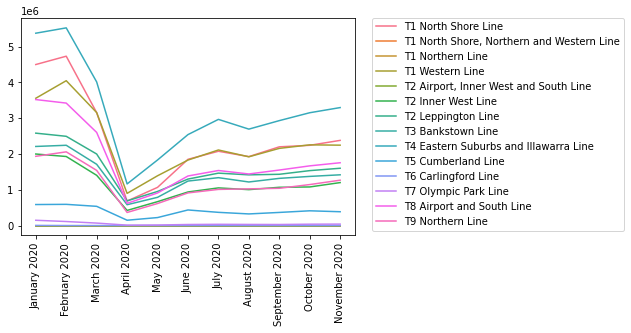

In [27]:
# plot data
sns.color_palette("tab10")
ax = sns.lineplot(data=cityTrain2020Df, dashes=False, sort=False)
plt.xticks(rotation = 90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Q3 Evaluation
The graph above shows a distinct drop in the number of opal trips from February to April 2020. The decline in the figure is coincident with the increasing number of COVID-19 cases in NSW and the direction made by many organisation for staff to work from home. 

After April 2020, NSW eases restrictions, which saw a steady increase in the number of trips.

Between July and August 2020 there was concern on a new cluster of NSW cases, which seems to cause a minor dip in the number of trips observed.

It would be interesting to see the number of trips in late December 2020 to early January 2021, where a more stringent restriction applies due to the increase of cases.

## Conclusions
- Since the redefinition of T1 North Shore, Northern and Western Line, the T4 Eastern Suburbs and Illawarra have consistently recorded the highest number of the trip.
- There is a similar proportion of trips made with different fare type. Throwing other datasets into the analysis may throw exciting observation.
- Overall, the number of trips in some lines has been decreased since COVID-19 detected in the Sydney metropolitan areas. While the number of trips has not reached the same figure as in previous years, it is interesting to see that there has been a steady number of trips made across the train lines.

## Acknowledgements
The Transport for NSW Open Data Hub for providing the Opal Trip – Train and Sydney Trains Network Map

## Disclaimer
Opinions expressed are solely my own and do not express my employer or data provider's views or opinions.